# Self-Driving Car Engineer Nanodegree

## German Traffic Sign Classification

Details in thre write up report.
Rubric: [link](https://review.udacity.com/#!/rubrics/481/view)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
%matplotlib inline

In [2]:
# Loading the data
# TODO: Fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Dataset Summary & Exploration

Number of training examples = 34799  Number of training labels = 34799
Number of validation examples = 4410  Number of validation labels = 4410
Number of testing examples = 12630  Number of test labels = 12630
Image data shape (width, height, channels) = (32, 32, 3)
Number of classes = 43
Visualizing sample type representation:


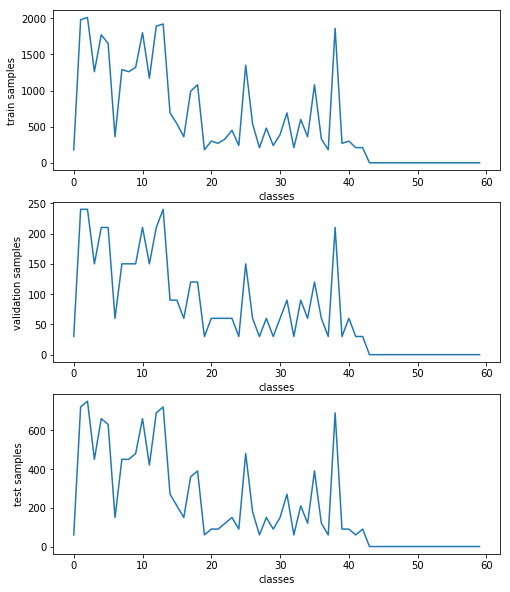

In [3]:
# Number of training examples and labels
n_train = X_train.shape[0]
n_train_label = y_train.shape[0]

# Number of validation examples and labels
n_validation = X_valid.shape[0]
n_validation_label = y_valid.shape[0]

# Number of testing examples and labels
n_test = X_test.shape[0]
n_test_label = y_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])

print("Number of training examples =", n_train, " Number of training labels =", n_train_label)
print("Number of validation examples =", n_validation, " Number of validation labels =", n_validation_label)
print("Number of testing examples =", n_test, " Number of test labels =", n_test_label)
print("Image data shape (width, height, channels) =", image_shape)

# Analizing the distribution of unique classes/labels there are in the datasets
train_label_count = np.zeros(60)
valid_label_count = np.zeros(60)
test_label_count = np.zeros(60)

for label in y_train:
    train_label_count[label] += 1

for label in y_valid:
    valid_label_count[label] += 1

for label in y_test:
    test_label_count[label] += 1

for i in range(train_label_count.shape[0]):
    if train_label_count[i] == 0:
        n_classes = i
        break
        
print("Number of classes =", n_classes)
print("Visualizing sample type representation:")
fig, axs = plt.subplots(3, 1, figsize=(8, 10))
axs[0].plot(train_label_count)
axs[0].set_xlabel('classes')
axs[0].set_ylabel('train samples')
axs[1].plot(valid_label_count)
axs[1].set_xlabel('classes')
axs[1].set_ylabel('validation samples')
axs[2].plot(test_label_count)
axs[2].set_xlabel('classes')
axs[2].set_ylabel('test samples')
plt.show()

Image index: 33080  Train label: 2  (signnames.csv in main folder)
Image index: 17614  Train label: 10  (signnames.csv in main folder)
Image index: 31066  Train label: 17  (signnames.csv in main folder)
Image index: 24336  Train label: 7  (signnames.csv in main folder)
Image index: 5582  Train label: 3  (signnames.csv in main folder)
Image index: 19478  Train label: 35  (signnames.csv in main folder)
Image index: 26334  Train label: 33  (signnames.csv in main folder)
Image index: 29519  Train label: 14  (signnames.csv in main folder)
Image index: 15230  Train label: 38  (signnames.csv in main folder)
Image index: 19494  Train label: 35  (signnames.csv in main folder)


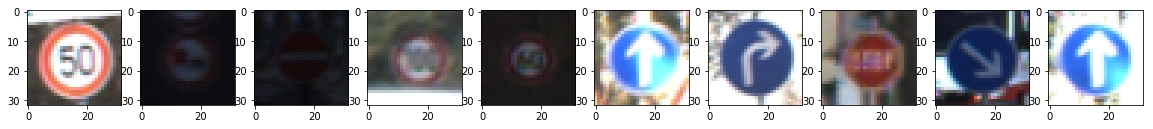

In [4]:
f, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    k = random.randint(0, len(y_train))
    img_sample = X_train[k, :, :, :]
    print("Image index:", k, " Train label:", y_train[k], " (signnames.csv in main folder)")
    ax[i].imshow(img_sample)

### Preprocessing the dataset

In [5]:
def preprocess (image_array):
    output_array = image_array.copy()
    # Convert to grayscale + CLAHE
    for i in range(len(image_array)):
        output_array[i,:,:,0] = cv2.cvtColor(image_array[i,:,:,:], cv2.COLOR_RGB2GRAY)
        output_array[i,:,:,0] = clahe.apply(output_array[i,:,:,0])
    # Normalization
    output_array = np.float32(output_array[:, :, :, :1]) / 128 -1
    
    return output_array

Image index: 780  Train label: 41  (signnames.csv in main folder)
Image index: 33265  Train label: 41  (signnames.csv in main folder)
Image index: 31963  Train label: 41  (signnames.csv in main folder)
Image index: 23420  Train label: 41  (signnames.csv in main folder)
Image index: 6219  Train label: 41  (signnames.csv in main folder)
Image index: 31457  Train label: 41  (signnames.csv in main folder)
Image index: 20702  Train label: 41  (signnames.csv in main folder)
Image index: 22828  Train label: 41  (signnames.csv in main folder)
Image index: 4559  Train label: 41  (signnames.csv in main folder)
Image index: 1086  Train label: 41  (signnames.csv in main folder)


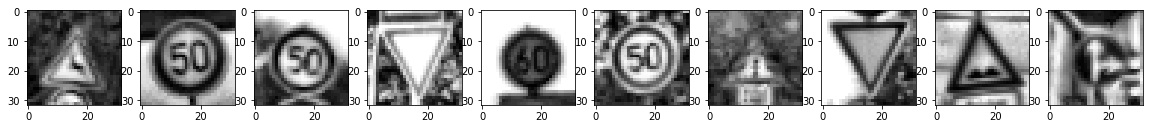

In [6]:
# Configuration 6
# Grayscale, adaptive histogram equalization, normalized
color_channels = 1

# Preprocessing images for NN
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(3,3))
input_train = preprocess(X_train)
input_valid = preprocess(X_valid)
input_test = preprocess(X_test)

f, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    k = random.randint(0, len(y_train))
    img_sample = input_train[k, :, :, 0]
    print("Image index:", k, " Train label:", y_train[i], " (signnames.csv in main folder)")
    ax[i].imshow(img_sample, cmap='gray')

### Model Architecture

In [7]:
# Configuration 6
def model(x, c_channels, classes):
    '''
    x: inputs, c_channels: color channels in input, classes: number of classes
    '''
    mu = 0
    sigma = 0.1
    keep_prob1 = 0.90
    keep_prob2 = 0.80
    keep_prob3 = 0.70

    weights = {
    'w1': tf.Variable(tf.truncated_normal(shape=(5, 5, c_channels, 32), mean = mu, stddev = sigma)),
    'w2': tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma)),
    'w3': tf.Variable(tf.truncated_normal(shape=(6400, 120), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(120, classes), mean = mu, stddev = sigma))}

    biases = {
    'b1': tf.Variable(tf.zeros(32)),
    'b2': tf.Variable(tf.zeros(64)),
    'b3': tf.Variable(tf.zeros(120)),
    'out': tf.Variable(tf.zeros(classes))}

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x32.
    layer1 = tf.nn.conv2d(x, weights['w1'], strides=[1, 1, 1, 1], padding='VALID')
    layer1 = tf.nn.bias_add(layer1, biases['b1'])
    layer1 = tf.nn.relu(layer1)
    layer1 = tf.nn.dropout(layer1, keep_prob1)
    
    # Pooling. Input = 28x28x32. Output = 14x14x32.
    layer1 = tf.nn.max_pool(
                layer1,
                ksize=[1, 2, 2, 1],
                strides=[1, 2, 2, 1],
                padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x64.
    layer2 = tf.nn.conv2d(layer1, weights['w2'], strides=[1, 1, 1, 1], padding='VALID')
    layer2 = tf.nn.bias_add(layer2, biases['b2'])
    layer2 = tf.nn.relu(layer2)
    layer2 = tf.nn.dropout(layer2, keep_prob2)

    # Flatten. Input = 10x10x64. Output = 6400.
    flat   = flatten(layer2)
    
    # Layer 3: Fully Connected. Input = 6400. Output = 120.
    layer3 = tf.matmul(flat, weights['w3'])
    layer3 = layer3 + biases['b3']
    layer3 = tf.nn.relu(layer3)
    layer3 = tf.nn.dropout(layer3, keep_prob3)
    
    # Layer 4: Fully Connected. Input = 120. Output = classes
    logits = tf.add(tf.matmul(layer3, weights['out']), biases['out'])
    
    return logits

### Train, Validate and Test the Model

In [12]:
# Configuration 6
config = 'config_6'
EPOCHS = 80
BATCH_SIZE = 128
learning_rate = 0.001

In [13]:
# Setting up tensorflow variables
x = tf.placeholder(tf.float32, (None, 32, 32, color_channels))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

# Setting up model
logits = model(x, color_channels, n_classes)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate)

training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
def evaluate(X_data, y_data, n_data):
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, n_data, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / n_data

In [15]:
# Model training (and evaluation)
with tf.Session() as sess:
    print("Training...")  
    sess.run(tf.global_variables_initializer())
   
    for i in range(EPOCHS):
        input_train, y_train = shuffle(input_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = input_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(input_valid, y_valid, n_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    tf.train.Saver().save(sess, config)
    print("Model saved")

Training...
EPOCH 1 ...
Validation Accuracy = 0.860
EPOCH 2 ...
Validation Accuracy = 0.914
EPOCH 3 ...
Validation Accuracy = 0.932
EPOCH 4 ...
Validation Accuracy = 0.940
EPOCH 5 ...
Validation Accuracy = 0.948
EPOCH 6 ...
Validation Accuracy = 0.946
EPOCH 7 ...
Validation Accuracy = 0.951
EPOCH 8 ...
Validation Accuracy = 0.951
EPOCH 9 ...
Validation Accuracy = 0.955
EPOCH 10 ...
Validation Accuracy = 0.959
EPOCH 11 ...
Validation Accuracy = 0.952
EPOCH 12 ...
Validation Accuracy = 0.966
EPOCH 13 ...
Validation Accuracy = 0.959
EPOCH 14 ...
Validation Accuracy = 0.958
EPOCH 15 ...
Validation Accuracy = 0.963
EPOCH 16 ...
Validation Accuracy = 0.966
EPOCH 17 ...
Validation Accuracy = 0.967
EPOCH 18 ...
Validation Accuracy = 0.962
EPOCH 19 ...
Validation Accuracy = 0.959
EPOCH 20 ...
Validation Accuracy = 0.967
EPOCH 21 ...
Validation Accuracy = 0.962
EPOCH 22 ...
Validation Accuracy = 0.962
EPOCH 23 ...
Validation Accuracy = 0.965
EPOCH 24 ...
Validation Accuracy = 0.966
EPOCH 25 ...


In [16]:
# Model testing
with tf.Session() as sess:
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(input_test, y_test, n_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./config_6
Test Accuracy = 0.958


---

## Test a Model on New Images

To get more insight how the model works, a few random german traffic sign image is collected from the web.

### Load and Output the Images

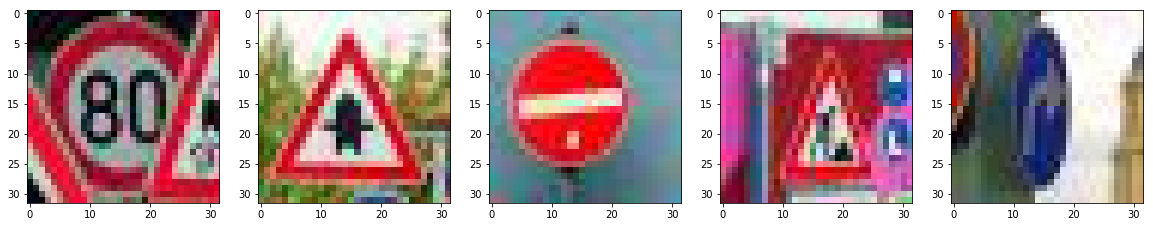

In [17]:
# Loading random images from internet (resized to 32x32)
example1 = cv2.imread('./examples/5.jpg')
example2 = cv2.imread('./examples/11.jpg')
example3 = cv2.imread('./examples/17.jpg')
example4 = cv2.imread('./examples/25.jpg')
example5 = cv2.imread('./examples/33.jpg')

# Preprocessing expects RGB
example1 = cv2.cvtColor(example1, cv2.COLOR_BGR2RGB)
example2 = cv2.cvtColor(example2, cv2.COLOR_BGR2RGB)
example3 = cv2.cvtColor(example3, cv2.COLOR_BGR2RGB)
example4 = cv2.cvtColor(example4, cv2.COLOR_BGR2RGB)
example5 = cv2.cvtColor(example5, cv2.COLOR_BGR2RGB)

# Creating array with the correct size for NN
test2 = np.uint8(np.empty([5, 32, 32, 3]))
test2[0,:,:,:] = example1
test2[1,:,:,:] = example2
test2[2,:,:,:] = example3
test2[3,:,:,:] = example4
test2[4,:,:,:] = example5

# Plot original images
f, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(test2[i, :, :, :])

# Preprocessing
input_test2 = preprocess(test2)
y_test2 = np.array([5, 11, 17, 25, 33])
n_test2 = input_test2.shape[0]


### Predict the Sign Type for Each Image

In [18]:
with tf.Session() as sess:
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint('.'))
    results = np.argmax(np.array(sess.run(logits, feed_dict={x: input_test2})),axis = 1)
print(results)

INFO:tensorflow:Restoring parameters from ./config_6
[ 5 11 17 25 11]


### Analyze Performance

In [19]:
pred = 0
for i in range(5):
    if y_test2[i] == results[i]:
        pred += 1
print('Accuracy on test images from the web: ~', int(pred/5*100), '%')

Accuracy on test images from the web: ~ 80 %


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [20]:
# Calculating the top 5 softmax probabilities
with tf.Session() as sess:
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint('.'))
    softmax = sess.run(tf.nn.softmax(logits), feed_dict = {x: input_test2})
    top5 = sess.run(tf.nn.top_k(softmax, k=5))

INFO:tensorflow:Restoring parameters from ./config_6


In [21]:
# Visualizing the top 5 softmax probabilities
print("Top 5 Predictions for each image :\n", top5.indices)
print("Top 5 corresponding probabilities :\n", np.round(top5.values*100,3))

Top 5 Predictions for each image :
 [[ 5  0 31  2  1]
 [11 40 27 28 18]
 [17 13 12 33  9]
 [25  2  5 24 27]
 [40 11 34  5 14]]
Top 5 corresponding probabilities :
 [[  9.39789963e+01   6.01900005e+00   1.00000005e-03   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  1.00000000e+02   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00]
 [  8.20120010e+01   1.79500008e+01   3.59999985e-02   2.00000009e-03
    1.00000005e-03]
 [  5.53499985e+01   4.23019981e+01   2.33599997e+00   1.20000001e-02
    0.00000000e+00]]
